# Models

this file is mostly me playing with the tools pytorch has to offer, and the resources RBC provided through the LSI program.


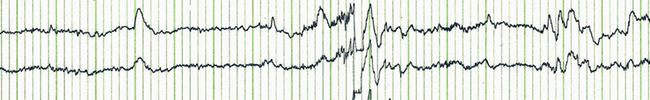

We essentially scan the waves with a detector and assign a score to each run of waves, indicating the likelihood the subject is lifting, grasping or holding while feeling 1 of the 3 emotions.

**Convultional Neural Networks(CNN)** systematize this idea of spatial invariance, exploiting it to learn useful representations with fewer parameters.

for more information on why **CNN**, please refer to my [blog](https://blogs.ubc.ca/sumitm/2022/05/26/first-e-a-d-convolutional-neural-networks-cnn/).

In [1]:
# loading the libraries
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import random
import torch.nn.functional as F
import argparse
from sklearn import metrics
from tqdm.notebook import tqdm
import gc
import shutil 
import mne
import pickle
import torch.utils.data as data_utils

KeyboardInterrupt: 

In [2]:
labels = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff',
       'Replace', 'BothReleased']
#chanelWant = ['Fp1', 'FC1', 'Fp2', 'P7', 'FC5', 'T7', 'F8', 'P4', 'CP5', 'P3', 'T8', 'Oz', 'FC6', 'O2', 'Cz', 'Fz', 'P8', 'C3', 'CP6', 'CP2', 'CP1', 'Pz', 'O1', 'F3', 'F7', 'C4', 'FC2', 'F4']

In [13]:
torch.manual_seed(2021)
np.random.seed(2021)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=1, help="number of epochs of training")
# change batch sizes for both datasets
# seed 
parser.add_argument("--seedbatchsize",type=int, default = 1024,help='size of batches for the seed dataset')
parser.add_argument("--batch_size", type=int, default=1024, help="size of the batches")

parser.add_argument("--lr", type=float, default=0.002, help="adam's learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.99, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=1, help="number of cpu threads to use during batch generation")
parser.add_argument("--in_len", type=int, default=2**10, help="length of the input fed to neural net")
# changing the signal channels to take 28 input channels
# uncomment for 28
parser.add_argument("--in_channels", type=int, default=28, help="number of signal channels")
#parser.add_argument("--in_channels", type=int, default=22, help="number of signal channels")
# changing the signal channels to output 
parser.add_argument("--outMotion_channels", type=int, default=6, help="number of motion classes")
parser.add_argument("--outEmotion_channels", type=int, default=1, help="number of emotion classes")
parser.add_argument("--chunk", type=int, default=1000, help="length of splited chunks")
opt, unknown = parser.parse_known_args()
print(device)

cuda


## Disclaimer: this is my first time using a GPU to train Neural Networks
As one would expect i faced challenges with assigning it to the notebook and memory.
the code below would clear the GPU for running the neural network again, this was found after spending countless hours interrupting and restarting the kernel and jupyter notebook.
```python
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
```

In [4]:
# Reading the dataset
with open('trainset.pickle','rb') as f:
    trainset = pickle.load(f)
with open('labels.pickle','rb') as f:
    gt = pickle.load(f)
with open('Seeddata.pickle', 'rb') as f:
    SeedTrainset = pickle.load(f)
with open('Seedvaliddata.pickle', 'rb') as f:
    SeedValidset = pickle.load(f)

In [6]:
# dimensions check and ensuring the data is loaded as expected
for i in SeedTrainset:
    print(i[0].shape)

(3, 72000)
(3, 96000)
(3, 237000)
(3, 187000)
(3, 147000)
(3, 258000)
(3, 297000)
(3, 69000)
(3, 264000)
(3, 141000)
(3, 174000)
(3, 172000)
(3, 189440)
(3, 0)
(3, 0)
(3, 72000)
(3, 96000)
(3, 237000)
(3, 187000)
(3, 147000)
(3, 258000)
(3, 297000)
(3, 69000)
(3, 264000)
(3, 141000)
(3, 174000)
(3, 172000)
(3, 228480)
(3, 0)
(3, 0)
(3, 72000)
(3, 96000)
(3, 237000)
(3, 187000)
(3, 147000)
(3, 258000)
(3, 297000)
(3, 69000)
(3, 264000)
(3, 141000)
(3, 174000)
(3, 172000)
(3, 183480)
(3, 0)
(3, 0)
(3, 72000)
(3, 96000)
(3, 237000)
(3, 187000)
(3, 147000)
(3, 258000)
(3, 297000)
(3, 69000)
(3, 264000)
(3, 141000)
(3, 174000)
(3, 172000)
(3, 234000)
(3, 240000)
(3, 155000)
(3, 72000)
(3, 96000)
(3, 237000)
(3, 187000)
(3, 147000)
(3, 258000)
(3, 297000)
(3, 69000)
(3, 264000)
(3, 141000)
(3, 174000)
(3, 172000)
(3, 234000)
(3, 240000)
(3, 155000)
(3, 72000)
(3, 96000)
(3, 237000)
(3, 187000)
(3, 147000)
(3, 258000)
(3, 297000)
(3, 69000)
(3, 264000)
(3, 141000)
(3, 174000)
(3, 172000)
(3, 

## Data input
as i am facing issues to read the data into the data loader for the indices, i am going to create a an array of 3* shape of the eeg data, with the dummy value representing the emotion

for the SEED data set we can split the data differently for train/test/ and validation.

In [5]:
# train valid split
valid_dataset = trainset[-2:]
valid_gt = gt[-2:]
trainset = trainset[:-2]
gt = gt[:-2]

Resample Data function, deals with the issue of no-events chunks in the Motion dataset. I use it for the Emotions dataset as well, even though it dosen't really need it.

In [6]:
def resample_data(gt, chunk_size=opt.chunk):
    """
    split long signals to smaller chunks, discard no-events chunks  
    """
    total_discard_chunks = 0
    mean_val = []
    threshold = 0.01
    index = []
    
    for i in range(len(gt)):
        for j in range(0, gt[i].shape[1], chunk_size):
            mean_val.append(np.mean(gt[i][:, j:min(gt[i].shape[1],j+chunk_size)]))
            if mean_val[-1] < threshold:  # discard chunks with low events time
                total_discard_chunks += 1
            else:
                index.extend([(i, k) for k in range(j, min(gt[i].shape[1],j+chunk_size))])

    plt.plot([0, len(mean_val)], [threshold, threshold], color='r')
    plt.scatter(range(len(mean_val)), mean_val, s=1)
    plt.show()
    print('Total number of chunks discarded: {} chunks'.format(total_discard_chunks))
    print('{}% data'.format(total_discard_chunks/len(mean_val)))
    del mean_val
    gc.collect()
    return index

## Datasets and Dataloaders

this was an intersting feautre of pytorch, as i need to convert every array to a tensor, to use pytorch neural network.

It took me a while to get used to this concept even though it has similar notation to numpy arrays.

I created 2 different classes one for Emotion and the other for Motion, to meet the different input data specifications.

In [8]:
# batch sizes is how the dataloader loads in the dataset
opt.seedbatchsize

10240

In [2]:
def subsetData(n,dataset):
    '''
    takes in n number of records and dataset
    returns the subset of the dataset.
    '''
    indices = torch.arange(n)
    seed_sub = data_utils.Subset(dataset,indices)
    return(seed_sub)
    

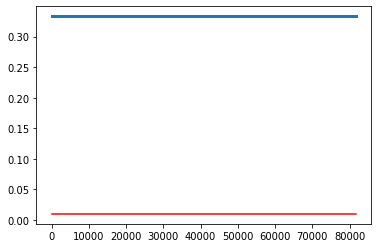

Total number of chunks discarded: 0 chunks
0.0% data


In [7]:

#the data loader for the SEED dataset


class EEGSEEDSignalDataset(Dataset):
    def __init__(self, data, soft_label=True, train=True):
        self.data = [el[1] for el in data]
        self.gt = [el[0] for el in data]
        self.train = train
        self.soft_label = soft_label
        self.eps = 1e-7
        # standardization steps
        if train:
            self.index = resample_data(self.gt)
        else:
            self.index = [(i, j) for i in range(len(data)) for j in range(data[i].shape[1])]
        for i,dt in enumerate(self.data):
            m = np.mean(dt,axis=0,keepdims=True)
            s = np.std(dt,axis=0,keepdims=True)
            dt = dt-m
            dt = dt/(s+self.eps)
            self.data[i] = dt
    
    def __getitem__(self, i):
        i,j = self.index[i]

        raw_data, label = self.data[i][:,max(0, j-opt.in_len+1):j+1],np.argwhere(self.gt[i][:,j]==1)[0]
        
        pad = opt.in_len - raw_data.shape[1]
        if pad:
            raw_data = np.pad(raw_data, ((0,0),(pad,0)), 'constant',constant_values=0)

        raw_data, label = torch.from_numpy(raw_data.astype(np.float32)),\
                            torch.from_numpy(label.astype(np.float32))
        if self.soft_label:
            label[label < .02] = .02
        return raw_data, label
            
    
    def __len__(self):
        return len(self.index)
    
seeddataset = EEGSEEDSignalDataset(SeedTrainset)
# since the emotion dataset is much larger than the motion, i selected a subset of the dataset for the dataloader
seed_10k = subsetData(4548000,seeddataset)

# -- the gpu crashed when i used the whole dataset for training.
# seeddataloader = DataLoader(seeddataset, batch_size = opt.seedbatchsize,\
#                 num_workers = opt.n_cpu, shuffle=True)

seeddataloader = DataLoader(seed_10k, batch_size = opt.seedbatchsize,\
                num_workers = opt.n_cpu, shuffle=True)

testing the getitem function of the class

In [10]:
seeddataset[0]

(1,)


(tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.7811],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0212],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -1.9799],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -1.9175],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -1.8094],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.7914]]),
 tensor([2.]))

Below is the class to read the Motion dataset into the dataloader, after standardizing. there were some errors that were difficult to debug hence implemented set_trace from the debugger.

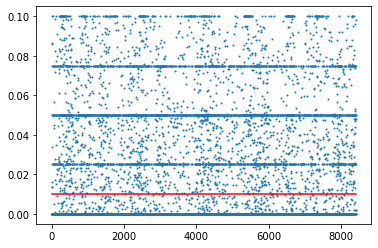

Total number of chunks discarded: 3865 chunks
0.45940805895637704% data
4548000


In [14]:
#From IPython.core.debugger import set_trace()

class EEGSignalDataset(Dataset):
    def __init__(self, data, gt, soft_label=True, train=True):#b, seed = False):
        self.data = data
        self.gt = gt
        self.train = train
        self.soft_label = soft_label
        self.eps = 1e-7
        # standardization steps
        if train:
            self.index = resample_data(gt)
        else:
            self.index = [(i, j) for i in range(len(data)) for j in range(data[i].shape[1])]
        for i,dt in enumerate(self.data):
            m = np.mean(dt,axis=0,keepdims=True)
            s = np.std(dt,axis=0,keepdims=True)
            dt = dt-m
            dt = dt/(s+self.eps)
            self.data[i] = dt
    
    def __getitem__(self, i):
        i, j = self.index[i]

        raw_data, label = self.data[i][:,max(0, j-opt.in_len+1):j+1], \
                self.gt[i][:,j]
        
        pad = opt.in_len - raw_data.shape[1]
        if pad:
            raw_data = np.pad(raw_data, ((0,0),(pad,0)), 'constant',constant_values=0)

        raw_data, label = torch.from_numpy(raw_data.astype(np.float32)),\
                            torch.from_numpy(label.astype(np.float32))
        if self.soft_label:
            label[label < .02] = .02
        return raw_data, label
#        return {'raw_data': raw_data, 'ground_truth':label}   
    
    def __len__(self):
        return len(self.index)
try:    
    dataset = EEGSignalDataset(trainset, gt) 
    dataloader = DataLoader(dataset, batch_size = opt.batch_size,\
                                           num_workers = opt.n_cpu, shuffle=True)
    print(len(dataset))

except Exception:
    print(traceback.format_exc())
    # or
    print(sys.exc_info()[2])

Shown below the 20 time difference between Motion and the Emotion dataset,need to increase the batch sizes to meet the dataloader dimensions

In [12]:
print(len(seeddataset))
print(len(dataset))

81730640
4548000


In [13]:
print(len(seeddataloader))
print(len(dataloader))

4442
4442


check to see if the dataset has appropriately loaded

In [23]:
seed_10k

## Network Architecture


below is the training loop i found on the net, to work with.

### the intial Neural Network architecture.
this the baseline we worked with.
```python
class NNet(nn.Module):
    def __init__(self, in_channels=opt.in_channels, out_channels=opt.outMotion_channels):
        super(NNet, self).__init__()
        self.hidden = 27
        self.net = nn.Sequential(
            nn.Conv1d(opt.in_channels, opt.in_channels, 5, padding=2),
            nn.Conv1d(self.hidden, self.hidden, 16, stride=16),
            nn.LeakyReLU(0.1),
            nn.Conv1d(self.hidden, self.hidden, 7, padding=3),
        )
        for i in range(6):
            self.net.add_module('conv{}'.format(i), \
                                self.__block(self.hidden, self.hidden))
        self.net.add_module('final', nn.Sequential(
            nn.Conv1d(self.hidden, out_channels, 1),
            nn.Sigmoid()
        ))
        
    def __block(self, in_channels, outchannels):
        return nn.Sequential(
            nn.MaxPool1d(2, 2),
            nn.Dropout(p=0.1, inplace=True),
            nn.Conv1d(inchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv1d(outchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
        )
    
    def forward(self, x):
        # Do your stuff here
        
        return self.net(x)
```

Shown below are the Neural Network architectures used respectively for Emotion and Motion Dataset separately with one head predicting emotion or motion.



the data input is slighly different for the emotion (SEEDNNET), in this implementation the labels are an array of 3xlen(eeg), one hot encoding with each column representing the emotion.
```python
class SeedNNet(nn.Module):
    def __init__(self, in_channels=opt.in_channels, out_channels=opt.outEmotion_channels):
        super(NNet, self).__init__()
        self.hidden = 27
        self.net = nn.Sequential(
            nn.Conv1d(opt.in_channels, opt.in_channels, 5, padding=2),
            nn.Conv1d(self.hidden, self.hidden, 16, stride=16),
            nn.LeakyReLU(0.1),
            nn.Conv1d(self.hidden, self.hidden, 7, padding=3),
        )
        for i in range(3):
            self.net.add_module('conv{}'.format(i), \
                                self.__block(self.hidden, self.hidden))
        self.net.add_module('final', nn.Sequential(
            nn.Conv1d(self.hidden, out_channels, 1),
            nn.Sigmoid()
        ))
        
    def __block(self, inchannels, outchannels):
        return nn.Sequential(
            nn.MaxPool1d(2, 2),
            nn.Dropout(p=0.1, inplace=True),
            nn.Conv1d(inchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv1d(outchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
        )
    
    def forward(self, x):
        return self.net(x)
```

## MultiOutput Neural Network

### 2 different structures of networks
My initial attmpt at creating a network that would be able to infer emotions and motions from the EEG signals.

This network was quite complicated as can be seen it had 3 baseline Conv1d layers and then in each iteration of the for loop it would pool, drop and then have 3 more layers. to estimate the 6 ranges of motion i had 18 layers for the data to pass through, similarly for the 3 ranges of motion 9 layers.

The model would then output from the motion head and the emotion head for a given eeg raw signal.

```python
class BothNNet(nn.Module):
    
    def __init__(self, in_channels=opt.in_channels, out_channels=[opt.outEmotion_channels,opt.outMotion_channels]):
        super(BothNNet, self).__init__()
        self.hidden = 27
        self.net = nn.Sequential(
            nn.Conv1d(opt.in_channels, opt.in_channels, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(self.hidden, self.hidden, 16, stride=16),
            nn.LeakyReLU(0.1),
            nn.Conv1d(self.hidden, self.hidden, 7, padding=3),
        )
        for i in range(6):
            self.net.add_module('conv{}'.format(i), \
                                self.__block(self.hidden, self.hidden))
        self.net.add_module('final', nn.Sequential(
            nn.Conv1d(self.hidden, out_channels[1], 1),
            nn.Sigmoid()
        ))
        for j in range(3):
            self.net.add_module('conv{}'.format(j), \
                                self.__block(self.hidden, self.hidden,emotion=True))
        self.net.add_module('final', nn.Sequential(
            nn.Conv1d(self.hidden, out_channels[0], 1),
            nn.Sigmoid()
        ))
            
        
    def __block(self, inchannels, outchannels,emotion=False):
        if emotion:
            return nn.Sequential(
            nn.MaxPool1d(2, 2),
            nn.Dropout(p=0.1, inplace=True),
            nn.Conv1d(inchannels, outchannels[0], 2, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv1d(outchannels, outchannels[0], 2, padding=2),
            nn.LeakyReLU(0.1),
        )
        return nn.Sequential(
            nn.MaxPool1d(2, 2),
            nn.Dropout(p=0.1, inplace=True),
            nn.Conv1d(inchannels, outchannels[1], 5, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv1d(outchannels, outchannels[1], 5, padding=2),
            nn.LeakyReLU(0.1),
        )
    
    def forward(self, x):
        self.net(x)
        
#         return self.net(x)

 ```   

### The goal with this architecture: Two head outputs instead of one
This code was the initial attempt to obtain predictions from two heads instead of one.
```python
class JamesNNet (nn.Module):
    def __init__(self, in_channels=opt.in_channels, out_channels=[opt.outEmotion_channels,opt.outMotion_channels]):
        super(JamesNNet, self).__init__()
        self.hidden = 28
        self.net = nn.Sequential(
            nn.Conv1d(opt.in_channels, opt.in_channels, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(self.hidden, self.hidden, 16, stride=16),
            nn.LeakyReLU(0.1),
            nn.Conv1d(self.hidden, self.hidden, 7, padding=3),
        )
        for i in range(1):
            
            self.net.add_module('conv{}'.format(i), \
                                self.__block(self.hidden, self.hidden))
            
            self.net.add_module('final', nn.Sequential(
            nn.Conv1d(self.hidden, out_channels[1], 1),
            nn.Sigmoid()
        ))
        for j in range(1):
            self.net.add_module('conv{}'.format(j), \
                                self.__block(self.hidden, self.hidden))
            self.net.add_module('final', nn.Sequential(
            nn.Conv1d(self.hidden, out_channels[0], 1),
            nn.Sigmoid()
        ))
            print(self.net)
        
    def __block(self, inchannels, outchannels):
#         print(outchannels)
            return nn.Sequential(
            nn.MaxPool1d(2, 2),
            nn.Dropout(p=0.1, inplace=True),
            nn.Conv1d(inchannels, outchannels, 2, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv1d(outchannels, outchannels, 2, padding=2),
            nn.LeakyReLU(0.1))
    def forward(self,x):
        nn_out = self.net(x)
#        print(nn_out)
        return(nn_out)
        
        #nn_out.add_module('conv'.format(1),x.__block(self.hidden,self.hidden))
        
        #x1 = nn_out.add_module('final',nn.Sequential(nn.Conv1d(self.hidden,out_channels[1],1), nn.Sigmoid()))
        
        #x2 = nn_out.add_module('final',nn.Sequential(nn.Conv1d(self.hidden,out_channels[0],1), nn.Sigmoid()))
        
        #return{'motion':x1,'emotion':x2}     
```

### GPU debugging
The GPU was having problems dealing with the computations on 81730640 records of data in batch sizes on 10240. I learnt about this by running a simple model shown below to asses if the GPU is working appropriately. 


In [4]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(13, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    return self.layers(x)

In [5]:
MLP().to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [12]:
print(y.shape)

torch.Size([1024, 1])


In [13]:
for i,(x,y) in enumerate(seeddataloader):
    print(x.shape)
    print(y.shape)
    break


torch.Size([10240, 28, 1024])
torch.Size([10240, 3])


Check to see the Feature and labels batch shape from the dataloader

In [81]:
#print(seeddataloader.dataset)
train_features, train_labels = next(iter(seeddataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


Feature batch shape: torch.Size([10240, 28, 1024])
Labels batch shape: torch.Size([10240, 3])


In [46]:

#dataloader
dataloader = DataLoader(dataset, batch_size = opt.batch_size,\
                                           num_workers = opt.n_cpu, shuffle=True)


### Training Loop

I found this example on the net, to get inspired from.

```python
def train(train_loader, network, loss_fn, num_training_epochs, key="img", augmentation=False):
    losses = []
    
    fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
    axes=fig.subplots(1,4)
    optimizer = optim.Adam(network.parameters(), lr=0.001)
    for epoch in range(num_training_epochs):
        iterator = iter(train_loader)
        network.train()
        for i in range(len(train_loader)):
            batch_cpu = next(iterator)
            batch_size = batch_cpu[key].shape[0]
            if augmentation:
                batch_cpu[] =

            batch = dict_to_device(batch_cpu, device)

            preds = network(batch)
            
            loss = loss_fn(preds[key], batch[key])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if epoch % max(num_training_epochs//1000,1) == 0:
          display_io(axes, preds, batch, losses, epoch)
    display.clear_output(wait=True)
```

This was the initial thought process/base and attempt to load in both dataloaders to run the neural network on. The steps to improve the taining loop.

as can be seen, we first define the nnet, lose functions and the optimizers, then for each epoch we iterate through the dataset, calculate prediction, calculate loss on that prediction optimise on it through back propagation and then add it to our loss history list for the train loss figure at the end of the file.

the goal is to load both datasets, to iterate through one and make predictions on emotions and motions, there are many challenges as one would expect.

1. Space, we cannot use a lot of space on the GPU to train hence need to pay attention to space complexity of our datasets
2. If we load in the data appropriately, how would we iterate on our objectives. since the emotion only has labels on emotions and the motion only has them on motions.
3. how would we iterate and optimise on our loss function?

A custom loss function migh be helpful here. [here is a link to learn more.](https://blog.paperspace.com/pytorch-loss-functions/?fbclid=IwAR0FMYON5e-cxHfzoBjNJdOf_K5Gk2FewWzT-qvmjpIBoCpmTJg8Z0RJxUE#:~:text=Loss%20functions%20in%20PyTorch%20PyTorch%20comes%20out%20of,module%2C%20PyTorch’s%20base%20class%20for%20all%20neural%20networks)


```python
nnet = NNet()
nnet.to(device)
loss_fnc = nn.BCELoss()
adam = optim.Adam(nnet.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
loss_his, train_loss = [], []
nnet.train()

for epoch in range(opt.n_epochs):
    p_bar = tqdm(dataloader)
    s_bar = tqdm(seeddataloader)

    for i, (x, y) in enumerate(p_bar):
        x, y = x.to(device), y.to(device)
        pred = nnet(x)
        loss = loss_fnc(pred.squeeze(dim=-1), y)
        
        adam.zero_grad()
        loss.backward()
        adam.step()
        train_loss.append(loss.item())

        p_bar.set_description('[Loss: {}]'.format(train_loss[-1]))
        if i % 50 == 0:
            loss_his.append(np.mean(train_loss))
            train_loss.clear()
    print('[Epoch {}/{}] [Loss: {}]'.format(epoch+1, opt.n_epochs, loss_his[-1]))
    
torch.save(nnet.state_dict(), 'testmodel.pt')
```

The initial training loop using the 2nd version of the neural network.
```python
nnet = JamesNNet()
nnet
loss_fnc = nn.BCELoss()
adam = optim.Adam(nnet.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
loss_his, train_loss = [], []
nnet.train()

# push this into james training function
for epoch in range(opt.n_epochs):
    
    p_bar = tqdm(seeddataloader) # emotion
    s_bar = tqdm(dataloader) # motion
    nsamples = 100
    
    if i > nsamples:
        break
    for i, (x, y) in enumerate(p_bar):
        if i> 10:
            break
        print(x.shape)
        print(y.shape)    
        x, y.motion = x, y
        pred = nnet(x)
        print(pred.shape)
        print(pred[:,:,].shape)
        y.motion = y.motion
        lossMotion = loss_fnc(pred.squeeze(), y.motion)
        adam.zero_grad()
        lossMotion.backward()
        adam.step()
        train_loss.append(lossMotion.item())
        p_bar.set_description('[Loss: {}]'.format(train_loss[-1]))
        
    
    for j,(a,b) in enumerate(s_bar):
        if j> nsamples:
            break

        a, b.emotion = a, b
        pred = nnet(x)
        lossEmotion = loss_fnc(pred.squeeze(dim=-1), y.emotion)
        
        adam.zero_grad()
        lossEmotion.backward()
        adam.step()
        train_loss.append(lossEmotion.item())
        p_bar.set_description('[Loss: {}]'.format(train_loss[-1]))
        
        
    
    loss = lossMotion + lossEmotion
    loss.backward()
    if i % 50 == 0:
            loss_his.append(np.mean(train_loss))
            train_loss.clear()
    print('[Epoch {}/{}] [Loss: {}]'.format(epoch+1, opt.n_epochs, loss_his[-1]))
    
    
torch.save(nnet.state_dict(), 'bothtestmodel.pt')
```

### The final version of the train loop
more comments on the final notebook.
```python
from operator import xor

nnet = MainNNet()

nnet.to(device)
m_loss_fnc = nn.BCELoss()
e_loss_fnc = nn.CrossEntropyLoss()
adam = optim.Adam(nnet.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
loss_his, train_loss = [], []
nnet.train()
stop = 0 # indicates that iterator is dry and should not swap anymore
flag = 0 # used to alternate training to optimize between the two objectives
alt_rate = 20 # alternate every 20 iterations
flag_map_str = {0: 'emotion', 1: 'motion'} # set up map to grab proper prediction based on flag

for epoch in range(opt.n_epochs):
        p_bar = tqdm(seeddataloader) # emotion
        s_bar = tqdm(dataloader) # motion

        stop = 0
        iter_p = iter(p_bar)
        iter_s = iter(s_bar)
        its = len(p_bar) + len(s_bar)

        for curr_it in range(its):

                # make sure we are not swapping if iterator is at end for one (could also oversample to fix bias)
                if stop != 1:
                        # flip the flag every alt_rate
                        if curr_it % alt_rate == 0:
                                flag = xor(flag, 1)

                try:
                        (x , y) = next(iter_p) if flag==0 else next(iter_s)
                except:
                        stop=1
                        flag = xor(flag, 1)
                        curr_it=curr_it - 1
                        continue
                
                x, y = x.to(device), y.to(device)
                pred = nnet(x)
                if flag == 0:
                    
                    loss = e_loss_fnc(pred[flag_map_str[flag]], y)
                else:
                    loss = m_loss_fnc(pred[flag_map_str[flag]], y)

                adam.zero_grad()
                loss.backward()
                adam.step()
                train_loss.append(lossMotion.item())
```

## The Training Loss plots
to illustrate how the model is working.

shown below is the taining loss for just predicitions on the motion dataset and then just for the emotions dataset. As can be seen with the initial arhitecture the model works better with motion, than the emotion dataset.

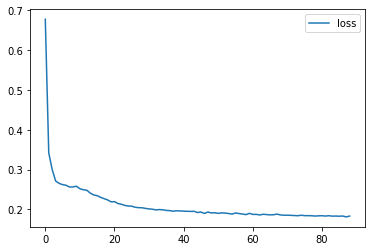

In [15]:
plt.plot(range(len(loss_his)), loss_his, label='loss')
plt.legend()
plt.show()

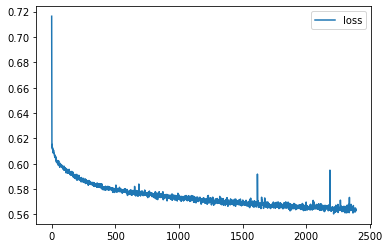

In [89]:
plt.plot(range(len(loss_his)), loss_his, label='loss')
plt.legend()
plt.show()